In [98]:
import pandas as pd
import seaborn as sns
import re, string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier

In [52]:
df=pd.read_csv(r'C:\Users\dipay\Work\My own shit\Data\training16m.csv',names = ['target','ids','date','flag','user','text'])

In [53]:
df=df[['target','text']]

In [54]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [55]:
df.isnull().count()

target    1600000
text      1600000
dtype: int64

C:\Users\dipay\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

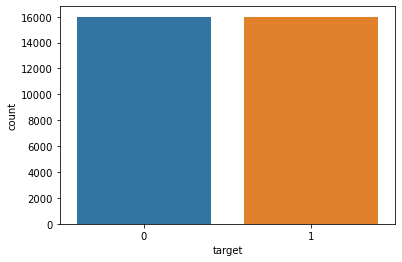

In [60]:
sns.countplot(df.target)

In [58]:
df['target'] = df['target'].replace(4,1)
# splitting categories
df_positive = df[df['target'] == 1]
df_negative = df[df['target'] == 0]
# sampling
df_positive = df_positive.iloc[:16000]
df_negative = df_negative.iloc[:16000]
# concatenation
df = pd.concat([df_positive, df_negative])
len(df)

32000

In [59]:
def clean_tweet(text):
    text=text.lower()
    text = re.sub('@[^\s]+', '', text)
    text = re.sub('((https?://[^\s]+)|(www\.[^\s]+))','',text)
    text = text.translate(str.maketrans('','',string.punctuation))
    
    tokens = word_tokenize(text)
    wordLemm = WordNetLemmatizer()
    final_words = []
    for token in tokens:
      # suppression of stop words
      if token not in stop_words and len(token) > 1:
        lemm = wordLemm.lemmatize(token)
        final_words.append(lemm)
    return ' '.join(final_words)

In [61]:
df['tweet'] = df['text'].apply(lambda x: clean_tweet(x))
df.head()

,target,text,tweet
800000,1,I LOVE @Health4UandPets u guys r the best!!,love guy best
800001,1,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S...",thanks twitter add sunisa got meet hin show dc...
800003,1,Being sick can be really cheap when it hurts t...,sick really cheap hurt much eat real food plus...
800004,1,@LovesBrooklyn2 he has that effect on everyone,effect everyone


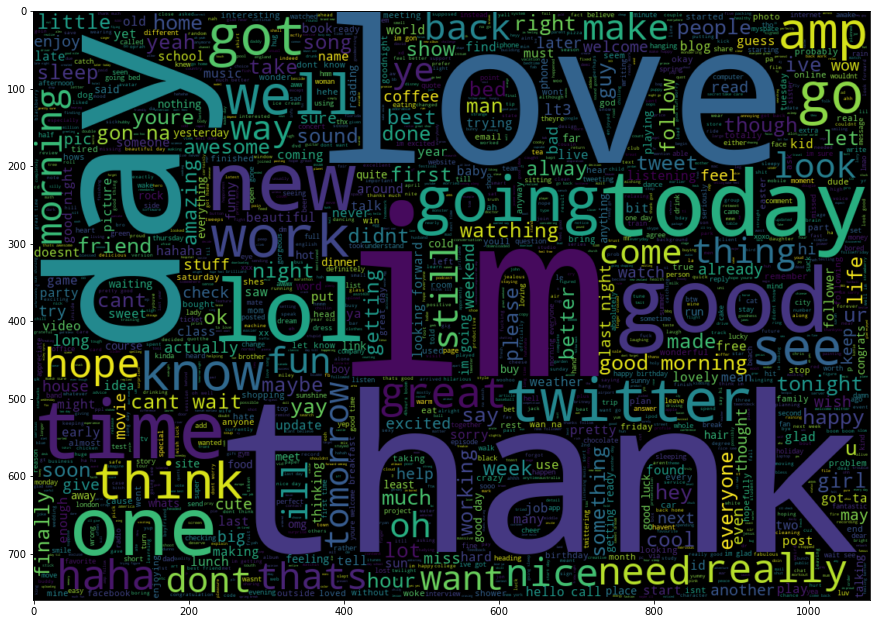

In [74]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1080 , height = 760).generate(" ".join(df[df.target == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear')

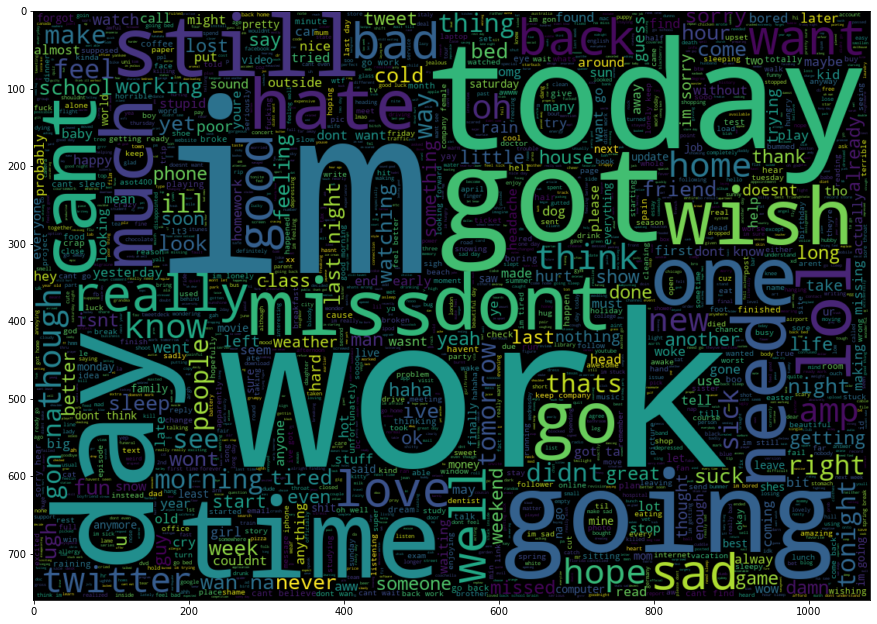

In [75]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1080 , height = 760).generate(" ".join(df[df.target == 0].tweet))
plt.imshow(wc , interpolation = 'bilinear')

In [78]:
x_train,x_test,y_train,y_test=train_test_split(df['tweet'].values, df['target'].values, test_size=0.2, random_state=264)

In [81]:
count_vectorizer=CountVectorizer()

countVec_train=count_vectorizer.fit_transform(x_train) 
countVec_test=count_vectorizer.transform(x_test)
print("count_train : ", countVec_train.shape)
print("count_test : ", countVec_test.shape)

count_train :  (25600, 24999)
count_test :  (6400, 24999)


In [87]:
np.random.seed(264)

rf_clf_countVec = RandomForestClassifier()
rf_clf_countVec = rf_clf_countVec.fit(countVec_train, y_train)

In [88]:
y_pred = rf_clf_countVec.predict(countVec_test)

score=accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 73.94%


Predicted,0,1
True,,
0,2370,813
1,855,2362


In [91]:
lr_clf_countVec = LogisticRegression(max_iter=100, solver='liblinear')
lr_clf_countVec = lr_clf_countVec.fit(countVec_train, y_train)

In [92]:
y_pred = lr_clf_countVec.predict(countVec_test)

score=accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 74.72%


Predicted,0,1
True,,
0,2327,856
1,762,2455


In [100]:
xgb_model = XGBClassifier(max_dept= 6, n_estimators=1000).fit(countVec_train, y_train)
prediction = xgb_model.predict(countVec_test)
score=accuracy_score(prediction,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

[01:04:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_dept" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:04:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 85.5%


Predicted,0,1
True,,
0,2384,799
1,820,2397


In [95]:
tfidf_vectorizer=TfidfVectorizer()

tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

In [96]:
rf_clf_tfidf = RandomForestClassifier()
rf_clf_tfidf = rf_clf_tfidf.fit(tfidf_train, y_train)

In [97]:
y_pred = rf_clf_tfidf.predict(tfidf_test)

score=accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 74.7%


Predicted,0,1
True,,
0,2384,799
1,820,2397


In [104]:
xgb_model = XGBClassifier(max_dept= 8, n_estimators=1000,nthread =-1,eta = 0.1,gamma=10).fit(tfidf_train, y_train)
prediction = xgb_model.predict(tfidf_test)
score=accuracy_score(prediction,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

C:\Users\dipay\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_dept" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 85.2%


Predicted,0,1
True,,
0,2384,799
1,820,2397
